In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

import cfod
from cfod import catalog
from cfod.routines import waterfaller

import h5py
import scipy
import wget

#Goal:

- find first burst repeaters
- streamline getting the graphs out
- find way of getting the data files (not manually) -> wget usage maybe

In [11]:
data = catalog.as_dataframe()
data

,tns_name,previous_name,repeater_name,ra,ra_err,ra_notes,dec,dec_err,dec_notes,gl,...,width_fitb,width_fitb_err,sp_idx,sp_idx_err,sp_run,sp_run_err,high_freq,low_freq,peak_freq,excluded_flag
0,FRB20180725A,180725.J0613+67,-9999,93.42,0.039,-9999,67.07,0.210,-9999,147.29,...,0.000296,0.000076,38.20,3.70,-45.80,4.20,760.1,485.3,607.4,1
1,FRB20180727A,180727.J1311+26,-9999,197.72,0.130,-9999,26.42,0.260,-9999,24.76,...,0.00139,0.000170,3.80,1.80,-9.20,3.00,800.2,400.2,493.3,1
2,FRB20180729A,180729.J1316+55,-9999,199.40,0.120,-9999,55.58,0.084,-9999,115.26,...,<0.00010,-9999.000000,16.46,0.24,-30.21,0.38,692.7,400.2,525.6,1
3,FRB20180729B,180729.J0558+56,-9999,89.93,0.270,-9999,56.50,0.240,-9999,156.90,...,0.000314,0.000083,14.50,3.50,-14.60,3.50,800.2,441.8,657.5,1
4,FRB20180730A,180730.J0353+87,-9999,57.39,0.032,-9999,87.19,0.200,-9999,125.11,...,0.000468,0.000040,4.27,0.30,-11.31,0.48,759.2,400.2,483.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,FRB20190701A,-9999,-9999,277.47,0.210,-9999,59.04,0.220,-9999,88.29,...,0.000608,0.000057,-1.10,1.50,3.30,1.90,800.2,400.2,800.2,0
596,FRB20190701B,-9999,-9999,302.93,0.220,-9999,80.18,0.240,-9999,112.88,...,0.00063,0.000130,3.90,1.70,-11.80,3.10,732.8,400.2,471.5,0
597,FRB20190701C,-9999,-9999,96.36,0.230,-9999,81.63,0.270,-9999,132.18,...,0.00144,0.000160,46.20,9.00,-211.00,41.00,495.5,402.2,446.4,0
598,FRB20190701D,-9999,-9999,112.10,0.180,-9999,66.70,0.160,-9999,149.28,...,0.00140,0.000120,6.49,0.75,-20.90,1.60,651.8,400.2,467.6,0


In [12]:
def boxcar_kernel(width):
    width = int(round(width, 0))
    return np.ones(width, dtype="float32") / np.sqrt(width)


def find_burst(ts, min_width=1, max_width=128):
    min_width = int(min_width)
    max_width = int(max_width)
    # do not search widths bigger than timeseries
    widths = list(range(min_width, min(max_width + 1, len(ts)-2)))
    # envelope finding
    snrs = np.empty_like(widths, dtype=float)
    peaks = np.empty_like(widths, dtype=int)
    for i in range(len(widths)):
        convolved = scipy.signal.convolve(ts, boxcar_kernel(widths[i]), mode="same")
        peaks[i] = np.nanargmax(convolved)
        snrs[i] = convolved[peaks[i]]
    best_idx = np.nanargmax(snrs)
    return peaks[best_idx], widths[best_idx], snrs[best_idx]

def bin_freq_channels(data, fbin_factor=4):
    num_chan = data.shape[0]
    if num_chan % fbin_factor != 0:
        raise ValueError("frequency binning factor `fbin_factor` should be even")
    data = np.nanmean(data.reshape((num_chan // fbin_factor, fbin_factor) + data.shape[1:]), axis=1)
    return data

In [13]:
#find the download url and import the data for a burst given its tns_name from the Data table.

example_tns = data["tns_name"][13]

url_base = "https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/files/vault/AstroDataCitationDOI/CISTI.CANFAR/21.0007/data/waterfalls/data/"
waterfall_string = '_waterfall.h5'

url = url_base + example_tns +waterfall_string

Data_from_url = wget.download(url)

#print(url)
#Data_from_url

data = h5py.File(Data_from_url, "r")
data = data["frb"]
eventname = data.attrs["tns_name"].decode()
wfall = data["wfall"][:]
model_wfall = data["model_wfall"][:]
plot_time = data["plot_time"][:]
plot_freq = data["plot_freq"][:]
ts = data["ts"][:]
model_ts = data["model_ts"][:]
spec = data["spec"][:]
model_spec = data["model_spec"][:]
extent = data["extent"][:]
dm = data.attrs["dm"][()]
scatterfit = data.attrs["scatterfit"][()]
cal_obs_date = data.attrs["calibration_observation_date"].decode()
cal_source_name = data.attrs["calibration_source_name"].decode()
cal_wfall =  data["calibrated_wfall"][:]

dt = np.median(np.diff(plot_time)) # the delta (time) between time bins 
# dt in mu s
# this value is the same for both caliberated and uncalibrated data
ts_with_RFI = ts

q1 = np.nanquantile(spec, 0.25)
q3 = np.nanquantile(spec, 0.75)
iqr = q3 - q1

# additional masking of channels with RFI
rfi_masking_var_factor = 3

channel_variance = np.nanvar(wfall, axis=1)
mean_channel_variance = np.nanmean(channel_variance)

with np.errstate(invalid="ignore"):
    rfi_mask = (channel_variance > \
                rfi_masking_var_factor * mean_channel_variance) \
                | (spec[::-1] < q1 - 1.5 * iqr) | (spec[::-1] > q3 + 1.5 * iqr)
wfall[rfi_mask,...] = np.nan
model_wfall[rfi_mask,...] = np.nan
spec[rfi_mask[::-1]] = np.nan

# remake time-series after RFI masking
ts = np.nansum(wfall, axis=0)
model_ts = np.nansum(model_wfall, axis=0)


peak, width, snr = find_burst(ts)
print(f"Peak: {peak} at time sample, Width = {width*dt} ms, SNR = {snr}")

# bin frequency channels such that we have 16,384/16 = 1024 frequency channels 
wfall = bin_freq_channels(wfall, 16)

Peak: 48 at time sample, Width = 17.694719368591905 ms, SNR = 762.669603977056


<ipython-input-13-a4d20659e279>:45: RuntimeWarning: Degrees of freedom <= 0 for slice.
  channel_variance = np.nanvar(wfall, axis=1)
<ipython-input-12-95700737f8c1>:25: RuntimeWarning: Mean of empty slice
  data = np.nanmean(data.reshape((num_chan // fbin_factor, fbin_factor) + data.shape[1:]), axis=1)


In [14]:
ts.shape


(114,)

In [15]:
plot_time.shape

(114,)

(114,) (115,)


<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, *, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

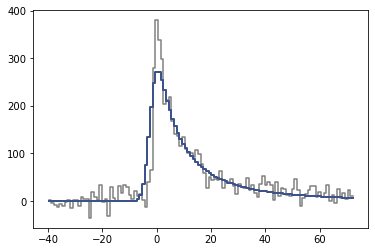

In [16]:
#reset plot_time
plot_time = data["plot_time"][:]

### time stamps relative to the peak
peak_idx = np.argmax(ts)
extent[0] = extent[0] - plot_time[peak_idx]
extent[1] = extent[1] - plot_time[peak_idx]
plot_time -= plot_time[peak_idx]

# prepare time-series for histogramming
plot_time -= dt / 2.
plot_time = np.append(plot_time, plot_time[-1] + dt)


### plot dynamic spectrum
wfall[np.isnan(wfall)] = np.nanmedian(wfall)   # replace nans in the data with the data median
# use standard deviation of residuals to set color scale
vmin = np.nanpercentile(wfall, 1)
vmax = np.nanpercentile(wfall, 99)

print(ts.shape, plot_time.shape)

### plot time-series
plt.plot(plot_time, np.append(ts, ts[-1]), color="tab:gray",
                drawstyle="steps-post", label='data')




cmap = plt.cm.viridis

### plot model time-series and spectrum
if scatterfit:
    plt.plot(plot_time, np.append(model_ts, model_ts[-1]),
                    color=cmap(0.25), drawstyle="steps-post", lw=2, label="model")
else:
    plt.plot(plot_time, np.append(model_ts, model_ts[-1]),
                    color=cmap(0.5), drawstyle="steps-post", lw=1, label="model")
    
plt.legend

plt.imshow
#plt.imshow




ValueError: x and y must have same first dimension, but have shapes (21,) and (20,)

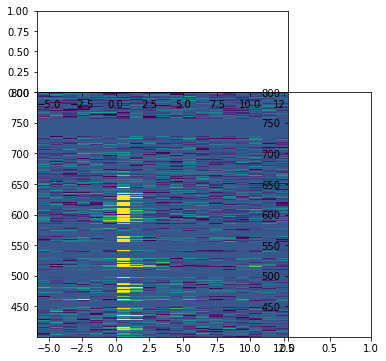

In [8]:
fig = plt.figure(figsize=(6,6))
## Set up the image grid
gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, width_ratios=[3, 1],
                        height_ratios=[1, 3], hspace=0.0, wspace=0.0)
data_im = plt.subplot(gs[2])
data_ts = plt.subplot(gs[0], sharex=data_im)
data_spec = plt.subplot(gs[3], sharey=data_im)


### time stamps relative to the peak
peak_idx = np.argmax(ts)
extent[0] = extent[0] - plot_time[peak_idx]
extent[1] = extent[1] - plot_time[peak_idx]
plot_time -= plot_time[peak_idx]

# prepare time-series for histogramming
plot_time -= dt / 2.
plot_time = np.append(plot_time, plot_time[-1] + dt)

cmap = plt.cm.viridis

### plot dynamic spectrum
wfall[np.isnan(wfall)] = np.nanmedian(wfall)   # replace nans in the data with the data median
# use standard deviation of residuals to set color scale
vmin = np.nanpercentile(wfall, 1)
vmax = np.nanpercentile(wfall, 99)

data_im.imshow(wfall, aspect="auto", interpolation="none",
                extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)

### plot time-series
data_ts.plot(plot_time, np.append(ts, ts[-1]), color="tab:gray",
                drawstyle="steps-post")

### plot spectrum
data_spec.plot(spec, plot_freq, color="tab:gray")

### plot model time-series and spectrum
if scatterfit:
    data_spec.plot(model_spec, plot_freq, color=cmap(0.25))
    data_ts.plot(plot_time, np.append(model_ts, model_ts[-1]),
                    color=cmap(0.25), drawstyle="steps-post", lw=2)
else:
    data_spec.plot(model_spec, plot_freq, color=cmap(0.5))
    data_ts.plot(plot_time, np.append(model_ts, model_ts[-1]),
                    color=cmap(0.5), drawstyle="steps-post", lw=1)


## BEautify plot
# remove some labels and ticks for neatness
plt.setp(data_ts.get_xticklabels(), visible=False)
data_ts.set_yticklabels([], visible=True)
data_ts.set_yticks([])
data_ts.set_xlim(extent[0], extent[1])
plt.setp(data_spec.get_yticklabels(), visible=False)
data_spec.set_xticklabels([], visible=True)
data_spec.set_xticks([])
data_spec.set_ylim(extent[2], extent[3])
plt.setp(data_im.get_xticklabels(), fontsize=9)
plt.setp(data_im.get_yticklabels(), fontsize=9)


#### highlighting the width of the pulse
data_ts.axvspan(max(plot_time.min(),
                        plot_time[peak] + 0.5 * dt \
                        - (0.5 * width) * dt),
                    min(plot_time.max(),
                        plot_time[peak] + 0.5 * dt \
                        + (0.5 * width) * dt),
                    facecolor="tab:blue", edgecolor=None, alpha=0.1)


##### add event ID and DM labels
xlim = data_ts.get_xlim()
ylim = data_ts.get_ylim()

# add 20% extra white space at the top
span = np.abs(ylim[1]) + np.abs(ylim[0])
data_ts.set_ylim(ylim[0], ylim[1] + 0.2 * span)
ylim = data_ts.get_ylim()

ypos = (ylim[1] - ylim[0]) * 0.9 + ylim[0]
xpos = (xlim[1] - xlim[0]) * 0.98 + extent[0]
data_ts.text(xpos, ypos, "{}\nDM: {:.1f} pc/cc\nSNR: {:.2f}".format(eventname, dm,snr), ha="right",
                va="top", fontsize=9)

data_im.locator_params(axis="x", min_n_ticks=3)
data_im.set_yticks([400, 500, 600, 700, 800])
data_im.set_ylabel("Frequency [MHz]", fontsize=9)
data_im.set_xlabel("Time [ms]", fontsize=9)


In [ ]:
plt.plot(plot_time, np.append(ts, ts[-1]), color="tab:gray", drawstyle="steps-post")
plt.imshow

In [ ]:
cal_ts = np.nanmean(cal_wfall, axis = 0)


In [ ]:
cal_wfall[np.isnan(cal_wfall)] = np.nanmedian(cal_wfall)   # replace nans in the data with the data median
#bin frequency channels such that we have 16,384/16 = 1024 frequency channels 
cal_wfall = bin_freq_channels(cal_wfall,16) 
vmin = np.nanpercentile(cal_wfall, 1)
vmax = np.nanpercentile(cal_wfall, 99)

times = np.arange(len(cal_ts))*dt
peak_idx = np.argmax(cal_ts)
times -= times[peak_idx]
times -= dt / 2.

extent[0] = times[0]
extent[1] = times[-1]

fig = plt.figure(figsize=(5,5), constrained_layout=True)
layout = """
A
C
"""
ax_dict = fig.subplot_mosaic(layout)
ax_dict["A"].imshow(cal_wfall, aspect="auto", vmin=vmin,vmax=vmax, extent = extent )
ax_dict["A"].set_title(f"Waterfall of {eventname} \n Calibrated to {cal_source_name} on {cal_obs_date}")
ax_dict["A"].set_yticks([400, 500, 600, 700, 800])
ax_dict["C"].plot(times,cal_ts, drawstyle="steps-post")
ax_dict["C"].set_xlabel("Time [ms]")
ax_dict["C"].set_title(f"Time Series of {eventname} \nCalibrated to {cal_source_name} on {cal_obs_date} \
        \n Peak flux = {cal_ts[peak_idx]:.3f} Jy")
ax_dict["A"].set_ylabel("Frequency [MHz]")
ax_dict["C"].set_ylabel("Flux [Jy]")
